In [126]:
import pathlib
import re

import matplotlib.pyplot as plt
import numpy as np
import tabulate

plt.style.use("slides")
np.set_printoptions(suppress=True, linewidth=250)

In [137]:
def myshorten(string: str):
    parts = re.split("/", string)
    indices = [3]
    shortened = '-'.join([parts[i] for i in indices])
    return shortened

infiles = {
'val': 'results/classifier_data/val_car_feasible_1614981888/val_car_feasible_ensemble/results_1615484563.npz',
'starts-far val': 'results/classifier_data/val_car_feasible_stars_far_1614982110+only-starts-far/val_car_feasible_ensemble/',
'planning, car': 'results/classifier_data/results/long_hooks_1/val_car_feasible_ensemble/results_1615484350.npz',
'planning, long hook': 'results/classifier_data/results/fss-no-starts-far-classifier-1/val_car_feasible_ensemble/results_1615484453.npz',
}

data = {}

for name, infile in infiles.items():
    infile_path = pathlib.Path(infile)
    datum = np.load(infile)
    print(name, list(datum.keys()))
    data[name] = datum

val ['stdevs', 'is_correct', 'probabilities']
planning, car ['stdevs', 'is_correct', 'probabilities']
planning, long hook ['stdevs', 'is_correct', 'probabilities']


In [138]:
table = []
for name, datum in data.items():
    uncertainty_estimate = datum['stdevs']
    # print(f'{myshorten(name):40s} {np.mean(uncertainty_estimate):.3f} {np.std(uncertainty_estimate):.3f}')
    table.append((name, np.mean(uncertainty_estimate), np.std(uncertainty_estimate)))
print(tabulate.tabulate(table, headers=['name', 'mean', 'std'], floatfmt='.3f'))


name                   mean    std
-------------------  ------  -----
val                   0.058  0.108
planning, car         0.102  0.152
planning, long hook   0.066  0.122


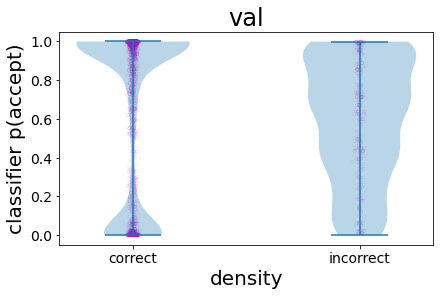

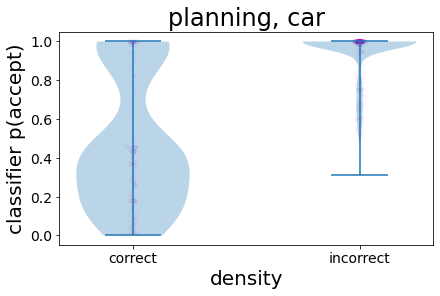

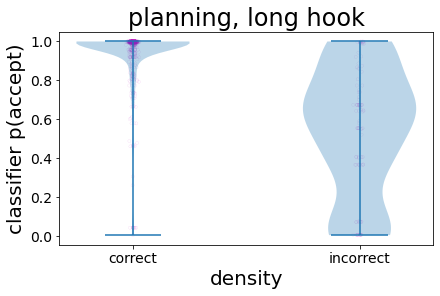

In [177]:
# Can the mean output probability of the ensemble tell us whether the classifier is wrong?
def noise_x_like(y, nominal_x):
    return np.random.normal(nominal_x, 0.01, size=y.shape[0])

def myscatter(ax, x, position, **kwargs):
    ax.scatter(noise_x_like(x, position), x, **kwargs)

for name, datum in data.items():
    probabilities = datum['probabilities']
    is_correct = datum['is_correct']
    _, ax = plt.subplots()
    is_correct_indices = np.argwhere(is_correct)
    is_incorrect_indices = np.argwhere(np.logical_not(is_correct))
    max_class_probabilities_correct = probabilities[is_correct_indices].squeeze()
    max_class_probabilities_incorrect= probabilities[is_incorrect_indices].squeeze()
    ax.set_title(name)
    myscatter(ax, max_class_probabilities_correct, 1, label='correct', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    myscatter(ax, max_class_probabilities_incorrect, 2, label='incorrect', edgecolors='m', s=10, facecolors='none', linewidth=0.05)
    ax.violinplot([max_class_probabilities_correct, max_class_probabilities_incorrect], [1, 2])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['correct', 'incorrect'])
    ax.set_xlabel("density")
    ax.set_ylabel("classifier p(accept)")

In [ ]:
# Can the mean output probability of the ensemble tell us whether the input is OOD?

In [ ]:
# Can the ensemble stdev tell us whether the classifier is wrong?

In [168]:
# Can the ensemble stdev tell us whether the input is OOD?

In [175]:
# Can the mean & stdev of ensemble together tell us whether the classifier is wrong?

In [ ]:
# Can the mean & stdev of ensemble together tell us whether the input is OOD?


In [ ]:
_, ax1 = plt.subplots()
_, ax2 = plt.subplots()

violin_handles = []
for name, datum in data.items():
    stdevs = np.load(infile.as_posix())


    ax1.hist(stdevs, bins=100, label=name, alpha=0.4)
    ax1.set_xlabel("ensemble stdev")
    ax1.set_ylabel("count")

    v = ax2.violinplot(stdevs)
    violin_handles.append(v["bodies"][0])
    ax2.set_xlabel("density")
    ax2.set_ylabel("classifier uncertainty")

ax1.legend()
ax2.legend(violin_handles, names)